#Tutorial Renderizando Conceitos com IA 
[Youtube Link](https://www.youtube.com/watch?v=JxTJeSTwv6A&ab_channel=DigitalFUTURESworld)
[Code]()

Code credits #Hotgrids



# Setup VQGAN and CLIP

In [1]:
#@title GPU Check
!nvidia-smi -L
!nvidia-smi --display=MEMORY -q

GPU 0: Tesla K80 (UUID: GPU-31ff30a8-640c-6650-dad3-ec66cac454e4)

==============NVSMI LOG==============

Timestamp                                 : Fri Apr 15 20:40:21 2022
Driver Version                            : 460.32.03
CUDA Version                              : 11.2

Attached GPUs                             : 1
GPU 00000000:00:04.0
    FB Memory Usage
        Total                             : 11441 MiB
        Used                              : 0 MiB
        Free                              : 11441 MiB
    BAR1 Memory Usage
        Total                             : 16384 MiB
        Used                              : 2 MiB
        Free                              : 16382 MiB



In [2]:
!git clone https://github.com/CompVis/taming-transformers  
%cd taming-transformers

# download a VQGAN with a larger codebook (16384 entries)
!mkdir -p logs/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_16384/configs
!wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
!wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/configs/model.yaml'
#vqgan wikiart
#!gdown https://drive.google.com/uc?id=1--elIwoE9RyGnjt_tWjUl3odBW4SO7OT -O 'logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
#!gdown https://drive.google.com/uc?id=1-0n1zDVCyDX-bjM4cxU6ZySp0qpt6nED -O 'logs/vqgan_imagenet_f16_16384/configs/model.yaml'

fatal: destination path 'taming-transformers' already exists and is not an empty directory.
/content/taming-transformers
--2022-04-15 20:40:21--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/f65cbddd-d4bc-47ad-9237-35537517155d/last.ckpt [following]
--2022-04-15 20:40:22--  https://heibox.uni-heidelberg.de/seafhttp/files/f65cbddd-d4bc-47ad-9237-35537517155d/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

logs/vqgan_imagenet 100%[===================>] 934.69M  14.9MB/s    in 62s     

2022-04-15 20:41:24 

Install minimal required dependencies.

In [3]:
%%capture
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define some loading utilities

In [4]:
!pip install einops

In [5]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None):
  model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  del model.loss
  return model.eval().requires_grad_(False)

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

## Load the VQGANs and define encode / decode

First, load (and optionally display) the model configs. Then, load the VQGAN models.

In [6]:
config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=False)
model16384 = load_vqgan(config16384, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


Define the reconstruction pipeline

In [7]:
import io
import os, sys
import requests
import PIL
from PIL import Image
import numpy as np
import random
import math

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

#from IPython.display import display, display_markdown
from IPython import display

def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    return torch.index_select(a, dim, order_index)

def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img

def encode_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  #print(f"VQGAN: latent shape: {z.shape[2:]}")
  #xrec = model.decode(z)
  return z

def decode_with_vqgan(z, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  #z, _, [_, _, indices] = model.encode(x)
  #print(f"VQGAN: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

def encode_with_vqgan_tensor(x, size, model=model16384):
  x = x.to(DEVICE)
  x = preprocess_vqgan(x)
  x = encode_with_vqgan(x, model)
  return x

def encode_with_vqgan_full(x, size, model=model16384):
  x = preprocess(Image.open(x), target_image_size=size)
  x = x.to(DEVICE)
  x = preprocess_vqgan(x)
  x = encode_with_vqgan(x, model)
  return x

## Install CLIP

In [8]:
#!pip install --no-deps git+https://github.com/openai/CLIP.git
#!pip install --no-deps ftfy regex tqdm
#
#import clip
#torch.set_grad_enabled(False)
#
#perceptor, clip_preprocess = clip.load("ViT-B/32", jit=False)
#perceptor.eval();

In [9]:
import torch
import fileinput

### Get CLIP

In [10]:
#!rm -rf CLIP/
!pip install --no-deps ftfy regex tqdm
!git clone https://github.com/openai/CLIP.git

fatal: destination path 'CLIP' already exists and is not an empty directory.


### Modify CLIP

In [11]:
%%writefile CLIP/clip/model.py
from collections import OrderedDict
from typing import Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.GELU()
        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        return x[0]


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.avgpool = nn.AvgPool2d(2)
        self.relu = nn.GELU()

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            for conv, bn in [(self.conv1, self.bn1), (self.conv2, self.bn2), (self.conv3, self.bn3)]:
                x = self.relu(bn(conv(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisualTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor, GiveConv1=False):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        y = x
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        if GiveConv1 == True:
            return x, y
        else:
            return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisualTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image, GiveConv1=False):
        return self.visual(image.type(self.dtype), GiveConv1=False)

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text, GiveConv1=False):
        image_features = self.encode_image(image, GiveConv1=False)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith(f"transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)
    model.load_state_dict(state_dict)
    return model.eval().requires_grad_(False)

Overwriting CLIP/clip/model.py


### Activate CLIP

In [12]:
from CLIP import clip
torch.set_grad_enabled(False)

perceptor, clip_preprocess = clip.load('ViT-B/32', jit=False)
perceptor.eval().float().requires_grad_(False);

# Optimize with CLIP

## Optimizer Functions

In [13]:
#@markdown Differentiable Augmentation for Data-Efficient GAN Training<br>
#@markdown Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han<br>
#@markdown https://arxiv.org/pdf/2006.10738<br>
#@markdown Code is inside this cell.

import torch
import torch.nn.functional as F


def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

In [14]:
eps = 1e-8

def HardTanh(x):
    x = x*2.0-1.0
    x = torch.tanh(x+x**5*.5)
    x = x*0.5+0.5
    return x

def SignPow(x, y):
    return torch.pow(torch.abs(x), y) * torch.sign(x)

def PowMean(x,y):
    output = SignPow(SignPow(x + eps, 1.0/y).mean(0,keepdim=True), y)
    output = torch.nan_to_num(output,0,0,0)
    return output

def PowMeanAll(x,y):
    output = SignPow(SignPow(x + eps, 1.0/y).mean(), y)
    output = torch.nan_to_num(output,0,0,0)
    return output

def Slerp(low, high, val):
    low_norm = low/torch.norm(low, dim=1, keepdim=True)
    high_norm = high/torch.norm(high, dim=1, keepdim=True)
    epsilon = 1e-7
    omega = (low_norm*high_norm).sum(1)
    omega = torch.acos(torch.clamp(omega, -1 + epsilon, 1 - epsilon))
    so = torch.sin(omega)
    res = (torch.sin((1.0-val)*omega)/so).unsqueeze(1)*low + (torch.sin(val*omega)/so).unsqueeze(1) * high
    return res

Basic_Augs = torch.nn.Sequential(
    T.Pad(padding=38, padding_mode='edge'),
    T.RandomAffine(degrees=10),
    T.RandomResizedCrop((224,224),scale=(0.2,1.0),ratio=(1.0/1.0, 1.0/1.0)),
    T.RandomHorizontalFlip(0.5),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
)

Random_Crop = T.RandomCrop((224,224))
Random_ResizedCrop = T.RandomResizedCrop((224,224),scale=(0.2,1.0),ratio=(1.0/1.0, 1.0/1.0))

CLIP_Normalization = T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def Loss_Check(img, prompt):
    #img_stack = torch.cat([Basic_Augs(img.unsqueeze(0)) for i in range(16)])
    img_stack = torch.cat([CLIP_Normalization(Random_ResizedCrop(DiffAugment(img.unsqueeze(0), 'color,translation,cutout'))) for i in range(16)])


    #sharp_mask   = TF.resize(sharpness,(224,224))
    #sharp_mask   = HardTanh(sharp_mask)
    #highpass     = img_stack - TF.gaussian_blur(img_stack, 3)
    #img_stack = HardTanh(sharp_mask * highpass + img_stack)

    encoded_stack = perceptor.encode_image(img_stack)

    similarity_pre = torch.cosine_similarity(prompt, encoded_stack, dim=-1)
    similarity = torch.arccos(0 - similarity_pre) / math.pi
    anti_jpeg_pre = torch.cosine_similarity(JPEG_Vector, encoded_stack, dim=-1)
    anti_jpeg = torch.arccos(0 - anti_jpeg_pre) / math.pi
    anti_text_pre = torch.cosine_similarity(prompt_non, encoded_stack, dim=-1)
    anti_text = torch.arccos(0 - anti_text_pre) / math.pi

    final_loss = 1.0 - similarity.mean() - anti_jpeg.mean() * 0.2 + anti_text.mean() * 0.2
    return final_loss



def format_image(x):
    #This is superior to clipping (clamping) due to clip/clamp having *no* gradient of its history to backprop in the
    #loss.backward() command. This tanh(x+x**5*0.5) shit is a soft, but not *too* soft, clipper that can be backpropped
    #and helps a lot. In theory and in observed practice. Could also just be in theory and the observations are placebo
    #but it makes sense so I'm keep.
    x = torch.tanh(x+x**5*0.5)
    x = (x + 1.)/2.
    return x

def save_image(x):
    x = format_image(x)
    x = T.ToPILImage()(x)
    return x

## Control Panel

In [15]:
#@title Define common prefixes for prompts by running this
imagenet_templates = ['a bad photo of a','a photo of many','a sculpture of a','a photo of the hard to see','a low resolution photo of the','a rendering of a','graffiti of a','a bad photo of the','a cropped photo of the','a tattoo of a','the embroidered','a photo of a hard to see','a bright photo of a','a photo of a clean','a photo of a dirty','a dark photo of the','a drawing of a','a photo of my','the plastic','a photo of the cool','a close-up photo of a','a black and white photo of the','a painting of the','a painting of a','a pixelated photo of the','a sculpture of the','a bright photo of the','a cropped photo of a','a plastic','a photo of the dirty','a jpeg corrupted photo of a','a blurry photo of the','a photo of the','a good photo of the','a rendering of the','a {} in a video game.','a photo of one','a doodle of a','a close-up photo of the','a photo of a','the origami','the {} in a video game.','a sketch of a','a doodle of the','a origami','a low resolution photo of a','the toy','a rendition of the','a photo of the clean','a photo of a large','a rendition of a','a photo of a nice','a photo of a weird','a blurry photo of a','a cartoon','art of a','a sketch of the','a embroidered','a pixelated photo of a','itap of the','a jpeg corrupted photo of the','a good photo of a','a plushie','a photo of the nice','a photo of the small','a photo of the weird','the cartoon','art of the','a drawing of the','a photo of the large','a black and white photo of a','the plushie','a dark photo of a','itap of a','graffiti of the','a toy','itap of my','a photo of a cool','a photo of a small','a tattoo of the',"a house made of", "a designer", "architecture"]

In [16]:
#@title Define Anti-JPEG
#JPEG_Vector = (torch.load("1000_ImageNet_224CropBadJPEG_ViT-B32_Encodes.pt")-torch.load("1000_ImageNet_224Crop_ViT-B32_Encodes.pt")).mean(0, keepdim=True).neg_().to(DEVICE)
#JPEGBad =  torch.load("1000_ImageNet_224CropBadJPEG_ViT-B32_Encodes.pt")
#JPEGBad /= JPEGBad.norm(dim=-1, keepdim=True)
#JPEGBad =  JPEGBad.mean(dim=0, keepdim=True)
#JPEGBad /= JPEGBad.norm()
#NotJPEG =  torch.load("1000_ImageNet_224Crop_ViT-B32_Encodes.pt")
#NotJPEG /= NotJPEG.norm(dim=-1, keepdim=True)
#NotJPEG =  NotJPEG.mean(dim=0, keepdim=True)
#NotJPEG /= NotJPEG.norm()
#Anti_Tiles = perceptor.encode_text(clip.tokenize(["tiles", "bricks", "squares", "pixels", "blocks", "cubes"]).to(DEVICE)).mean(0).unsqueeze(0).cpu()
#JPEG_Vector =  NotJPEG - JPEGBad - Anti_Tiles * 0.125
#JPEG_Vector /= torch.linalg.norm(JPEG_Vector)
#JPEG_Vector =  JPEG_Vector.to(DEVICE) #.neg_()

#print(JPEGBad.shape,NotJPEG.shape,JPEG_Vector.shape)

import base64

JPEG_Vector_Data = base64.b64decode("UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY3RvcmNoLl91dGlscwpfcmVidWlsZF90ZW5zb3JfdjIKcQAoKFgHAAAAc3RvcmFnZXEBY3RvcmNoCkZsb2F0U3RvcmFnZQpxAlgOAAAAOTQ3OTg1NDA5NDMzMTJxA1gDAAAAY3B1cQRNAAJ0cQVRSwBLAU0AAoZxBk0AAksBhnEHiWNjb2xsZWN0aW9ucwpPcmRlcmVkRGljdApxCClScQl0cQpScQsuUEsHCNwBHIqqAAAAqgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAGwANAGFyY2hpdmUvZGF0YS85NDc5ODU0MDk0MzMxMkZCCQBaWlpaWlpaWlpVa36+mrOXPN6xHzuRLPY93xHlPRg+ED5kL0Y+URqSPh7jTb7shh+9lquuPRaZjb2Z7LC9t1SZPVeM7T0tMxE+RiEFvxOJNby0yGw9IZBovZK/Gz4Cwh49V60mPlKXIb0qi1y8bwm5PWHCvr1sxqm9nI2Kvo33Pj12ARS+GkkWPvi9pL2qVYW9E5qhPl4IaD5aCEk7IJKSPWg24br9EMA97TxIPR7hIT07Ur27LDgLvtNQI73s73y+aJ7EvbHcr70ptBA+pgTcvDCIIj7fG9+9ZWz0PRY3jzso/Kw8CFWOPulTjT2elYg+aF3lvAEI1T07p/W9lIgvvnK+ML3BvAm919gavpik0byd5hI+H19hPX7rBz1H4gC67P8GPLvXRL0h76W9p1ePPY20gTz/b4U7DmqmPZOh+L0ii6w8hHQMvnP5ED46ZC++hZyZvXqGPj52fdK83HZjPexaOT6mvFW9FmYDPqRZc75CZIw9ZO1muxRcvr5Sfa09xkozvFY/fzyuGu895A8kPcS33z1diK+87adVvdcXjTqPzbc7C485PgOybb0X1K89HVjYvtreCrzndw88fyCivQBfIr7DnI+9RL+6vboIQr2v6Ee9f+sHvgH2Ubz7jXu8THOePlpWhDrYSRw9qYCzPlbvVD2NK9y8RxuTveR6vb2jvTe9ezIVPcuyVDx6EJy9F7o/PnrOjD02ENA9Ea3NPNq2I70fO7o9Wm6kvSR7S7xgeMw9X1Z5vY7q+70SqDU93yoaPstAdT0QrQi98ldtvos5+b0axcS9JVWPPcavr7ykNdm9g7AgvWOn773eO1q9DDYQPedOCb4UIR0+pfizvV4qRrzW8C89hqYTPbXZjjurKwK9VlP9PRfpGD1X8W6+LaINPpEHFD6Gpr+93CshvV5d9j2ckb08cQbmvZRVcD2FCFM9F86TvTivbr7NWGG9Mo3UvVZeI7zzBgo+hVdrvX8JtTxYwdM9XoCevBM8lD2qtNE8pOGivRC4k73WSAi98laaPZwEuD2ZLlo8mgbFPRnGq75I/fi9ejHCvUb0073vpis8tOTlvdbAMr1NExU+jeuKPHeOmzwXjkc+du7HPXMFRj11+fO9cQ0fPKZInz3mwmw9Lal4PlZyez3JFw4+pRr2PQIrLr5Ma1I+En+WvB/AxL2wVbu9kVymvhIvWz5Egx091mHJOi/sbz3wIh+91GNXvaxD1D0SV4S+sBAuvWqS870FRIe8CnEvPGI+HL3Ycfo8hJIhvaCTpT2ohZY8Hch/PuUYkz0/HkO9hHzJPEKCejynhcq8SH+Svbaklb0wXUI+MBcsPuMk8z3yfIq78L+gvRL0dL1olK+98Vx4veXBbL6A/rG9EDy1PbwgF77h9lK+9RxkPayKDj7w6M09J1Mgva20zL3IIz4+H1yRPBtbFr6gbyA+352fvWfNojzbXyC6D2QVPY9Ukz0Buyk99gf4PUHkL73PCWW9xgGlvDgFgrx59Qs9nMHvOr6pij2MM0Y8OjUiu5hLbT1WjxA9CUvyvg+zCT05UgU+UlcivvkeZL0+ZDS+w233PauYxbwDm/K9U+qCPS3w8T3jdvU9XnmVOaNxQD033Ug+9aHxPfsUy7vyg/u9m9n3PCM2hzzHhhm+zVezPHGiAD2Uwz89g8Lpvds2TT7sFNA8K5p/PNh0U7vVxxg+exSEvL7dSb2X+3692rWJPRuOyz07uBO+DC18vcrygLwHPNy9468svSLN7T3603Y9mHOtvT2cnD33Are9yrUjvgrtDr56NCq+1QMqvsU6WD5TmYY99lGnPWRCXj0NWcs9yVOnvduuIL4zTa89l7AQPWq2xL1nrio9SeiuO6ilmb1zrya8CukcvStyiL4neq29ZCiFvfqWIjx5xn49XJYmPnN4lz0x3RY9bPEGPo3rlTvj55O9Mrz/PdfEirtQScE9Idl7PsE1Gj7GKBK8Kp7gvcLSr715MG49YHvOPG9gtj0F1kY+UjHzvFbaHT7oW/k8MYk7PkrOHTz5Cwq+9OeQPYejor3hWjG+DxmJvUN1eL2MlmC99T4Svv6XG764Z94980Hkva3jKD4nLVo9Ai2rO6rSCbyYGke+l0PJvVOyw73DE8C8QYgpPs0d6708zpS8Ym5wPTMrOD71Lhy+LbxNO+iyVr6aKzw9lt62PC789Txdwz8+1y+hPCERbb0U7mM9y9nFvU6yCj03BOQ8veU+Pf56dz1NcR09Vm2+PTsZ7L01Kqm9/TvCPeKqSz7DS1G+1cFHPcu0Q7vlcYS+PFDTO17R7b6UuzI9qlSIvdtoHz6h1PC8SiDIvYaEpb2misO9YU+lPVhlXr3srIk9N8PgPGjQwzwBqFS+SCHcPcmWhz6msp697GpcvaJvkryTLO498k0zvbLsmDz6nfc8CmJDPiS5Uz6azCm9gmDyPRehrT1j9hW96bv+vfOPZzxfrxW9rdGSu+SHPLx7L0e+6Ma1veynIb0tAzG+xSETPfA2HL6yQw+++HVPvFzKND3yA8g9+iEZvfijq71/DqA8BfMJvgydGr45wKo9Iig8vq6W1D0jpRO94S2yvCWsmb3PTtY819GJvf6UNb5xkMS95Q0OPc1pIL6FuAu+C7ALPnqXoruEZU09UPkqvRf84r3EVSm8li/sPfRVGL0cTIM9rVRbvfyABbw/+Jw9ifiVu3QFir3Lbtm8qgFQPeq1qr263089VEclvW7HA75OwTi9o4wJvlBLBwgbGBE+AAgAAAAIAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL3ZlcnNpb25GQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMwpQSwcI0Z5nVQIAAAACAAAAUEsBAgAAAAAICAAAAAAAANwBHIqqAAAAqgAAABAAAAAAAAAAAAAAAAAAAAAAAGFyY2hpdmUvZGF0YS5wa2xQSwECAAAAAAgIAAAAAAAAGxgRPgAIAAAACAAAGwAAAAAAAAAAAAAAAAD6AAAAYXJjaGl2ZS9kYXRhLzk0Nzk4NTQwOTQzMzEyUEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAUAkAAGFyY2hpdmUvdmVyc2lvblBLBgYsAAAAAAAAAB4DLQAAAAAAAAAAAAMAAAAAAAAAAwAAAAAAAADEAAAAAAAAANIJAAAAAAAAUEsGBwAAAACWCgAAAAAAAAEAAABQSwUGAAAAAAMAAwDEAAAA0gkAAAAA")
JPEG_Vector_File = open("JPEG_Vector.pt", "wb")
JPEG_Vector_File.write(JPEG_Vector_Data)
JPEG_Vector_File.close()
JPEG_Vector = torch.load("JPEG_Vector.pt").to(DEVICE)
Anti_Tiles = perceptor.encode_text(clip.tokenize(["tiles", "bricks", "squares", "pixels", "blocks", "cubes"]).to(DEVICE)).mean(0).unsqueeze(0)
JPEG_Vector = JPEG_Vector - Anti_Tiles * 0.2


# <font color='red'> **Prompt and parameters**</font> 





In [125]:
#@title <font color='#429feb'>Reset memory and files</font> {vertical-output: true}
# If you're going to restart it all then run this to clear out some more memory
loss = None
img_root = None
img_test = None
optimizer = None

# Delete all images and video
!rm -rf /content/taming-transformers/output/*
!rm -f /content/out.mp4

import gc

torch.cuda.empty_cache()
gc.collect()

2340

In [126]:
#@markdown <font color='#429feb'>Prompts </font> 
prompt_pre = ["geometric pattern frei otto","unreal engine","Vray house design", "realism Hyper realism","light render beautiful","architecture design"] #@param {type:"raw"}
prompt_main    = ["modern house", "Made of Concrete and Glass", "architecture", "richard rogers design", "a house in the woods"] #@param {type:"raw"}

#@markdown <font color='#429feb'>Input Image</font> 
use_custom_input = True #@param {type:"boolean"}
custom_input_image = "/content/SAVOYE.jpg" #@param {type:"string"}


#@markdown <font color='#429feb'>Parameters</font> 
imagesize = 512 #@param {type:"integer"}
steps = 126 #@param {type:"integer"}
learning_rate = 0.8 #@param {type:"number"}
lr_min = 0.04 #@param {type:"number"}
lr_decay_steps = 25 #@param {type:"integer"}
weight_decay  = 0.15 #0.20 #0.15 #0.20
wd_min = 0.00
wd_decay_steps = 25

#@markdown <font color='#429feb'>Transformations (angle, translate, scale, shear) [see](https://pytorch.org/vision/stable/generated/torchvision.transforms.functional.affine.html#torchvision.transforms.functional.affine)</font> 
save_steps = 5 #@param {type:"number"}
modify_steps = 25 #@param {type:"number"}
affine_angle = 0 #@param {type:"slider", min:-180, max:180, step:1}
affine_translate = (0,0) #@param {type:"raw"}
affine_scale = 1.0 #@param {type:"number"}
affine_shear = 0 #@param {type:"slider", min:-180, max:180, step:1}


affine_angle = float(affine_angle)
affine_scale = float(affine_scale)
affine_shear = float(affine_shear)


print(prompt_pre)
print(prompt_main)
print("Custom image:",use_custom_input, custom_input_image)
print("Image Size:",imagesize)
print("Steps:",steps)
print("Learning Rates:", learning_rate, lr_min, lr_decay_steps)
print("Transformations:", affine_angle,affine_translate,affine_scale,affine_shear )


['geometric pattern frei otto', 'unreal engine', 'Vray house design', 'realism Hyper realism', 'light render beautiful', 'architecture design']
['modern house', 'Made of Concrete and Glass', 'architecture', 'richard rogers design', 'a house in the woods']
Custom image: True /content/SAVOYE.jpg
Image Size: 512
Steps: 50
Learning Rates: 0.8 0.04 25
Transformations: 0.0 (0, 0) 1.0 0.0


## Optimizer Brain

In [127]:
#@title <font color='#429feb'>Set loops</font> {vertical-output: true}


torch.set_grad_enabled(False)
!mkdir output/ &> /dev/null
import gc
torch.cuda.empty_cache()
gc.collect()

CLIP_Normalization = T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def EncodeImagePrompt(img):
    img_stack = []
    for i in range(5):
        for j in range(5):
            x_roll = i - 3
            y_roll = j - 3
            img_stack.append(torch.roll(img,(x_roll,y_roll),(-1,-2)).unsqueeze(0))
    img_stack = torch.cat(img_stack)
    img_stack = CLIP_Normalization(img_stack)
    encoded_stack = perceptor.encode_image(img_stack)
    encoded_stack /= encoded_stack.norm(dim=-1, keepdim=True)
    image_encoded  =  encoded_stack.mean(dim=0, keepdim=True)
    image_encoded  /= image_encoded.norm()
    return image_encoded #encoded_stack.mean(0, keepdim=True)

def EncodeMultiPrompt(prefix, main, suffix=None, suffix2=None, suffix3=None, mean=True):
    prompt_full = []
    for i in range(len(prefix)):
        for j in range(len(main)):
            prompt_merge = prefix[i] + " " + main[j]
            prompt_full.append(prompt_merge)
    if suffix != None:
        prompt_full_backup = prompt_full
        prompt_full = []
        for i in range(len(prompt_full_backup)):
            for j in range(len(suffix)):
                prompt_merge = prompt_full_backup[i] + " " + suffix[j]
                prompt_full.append(prompt_merge)
    if suffix2 != None:
        prompt_full_backup = prompt_full
        prompt_full = []
        for i in range(len(prompt_full_backup)):
            for j in range(len(suffix2)):
                prompt_merge = prompt_full_backup[i] + " " + suffix2[j]
                prompt_full.append(prompt_merge)
    if suffix3 != None:
        prompt_full_backup = prompt_full
        prompt_full = []
        for i in range(len(prompt_full_backup)):
            for j in range(len(suffix3)):
                prompt_merge = prompt_full_backup[i] + " " + suffix3[j]
                prompt_full.append(prompt_merge)
    prompts_encoded =  perceptor.encode_text(clip.tokenize(prompt_full).to(DEVICE))#.mean(0).unsqueeze(0)
    if mean == True:
        prompts_encoded /= prompts_encoded.norm(dim=-1, keepdim=True)
        prompt_encoded  =  prompts_encoded.mean(dim=0, keepdim=True)
        prompt_encoded  /= prompt_encoded.norm()
        return prompt_encoded
    if mean == False:
        return prompts_encoded


prompt = EncodeMultiPrompt(prompt_pre, prompt_main)

#This is just to put random shit in the prompt. The 2x multiplier is arbitrary and
#the hardtanh to limit it to (-1,1) is to prevent big outliers that might fuck up the gist
#of the prompt.
prompt = prompt + HardTanh(torch.randn_like(prompt) * 2.0) * 0.02

prompt_non_pre = ["words", "letters", "text", "writing", "font", "fonts", "signature", "signatures", "typeface", "typefaces", "handwriting"]
prompt_non_main = ["text", "writing", "font", "signature", "handwriting", ""]
prompt_non = EncodeMultiPrompt(prompt_non_pre, prompt_non_main)

prompt_non2_pre = ["cartoon", "cartoons", "anime", "animes", "flash animation", "flash game", "manga"]
prompt_non2_main = ["screenshot", ""]
prompt_non2 = EncodeMultiPrompt(prompt_non2_pre, prompt_non2_main)

#prompt = prompt - prompt_non * 0.1
#prompt = prompt - prompt_non2 * 0.1
#prompt = prompt + JPEG_Vector * 0.05
#prompt = prompt / torch.linalg.norm(prompt)
#prompt = prompt + JPEG_Vector * 0.05

#228 because it's going to be cropped after transforms
#image_prompt = T.ToTensor()(Image.open("balloons.png").resize((228,228),2)).to(DEVICE)
#image_prompt = EncodeImagePrompt(image_prompt)


#https://github.com/python-pillow/Pillow/blob/master/src/PIL/ImageColor.py#L148
solid_color = Image.new('RGB', (imagesize, imagesize), "#57A")

import math

imgsize = (imagesize,imagesize)
solid_color = Image.new('RGB', imgsize) #Create the image
innerColor = [250, 250, 250] #Color at the center
outerColor = [10, 12, 14] #Color at the corners

for y in range(imgsize[1]):
    for x in range(imgsize[0]):
        distanceToCenter = math.sqrt((x - imgsize[0]/2) ** 2 + (y - imgsize[1]/2) ** 2)
        distanceToCenter = float(distanceToCenter) / (math.sqrt(2) * imgsize[0]/2)
        r = outerColor[0] * distanceToCenter + innerColor[0] * (1 - distanceToCenter)
        g = outerColor[1] * distanceToCenter + innerColor[1] * (1 - distanceToCenter)
        b = outerColor[2] * distanceToCenter + innerColor[2] * (1 - distanceToCenter)
        solid_color.putpixel((x, y), (int(r), int(g), int(b)))

if use_custom_input == False:
  custom_input_image = "solid_color.jpg"

#solid_color = Image.open("/content/Sydiney.jpg").resize((imagesize,imagesize),2)
solid_color = T.ToTensor()(solid_color)**0.5
solid_color = TF.gaussian_blur(solid_color, (15,15))
solid_color = ((solid_color * 2 - 1) + (torch.rand_like(solid_color) * 2 - 1) * 0.5) * 0.5 + 0.5
solid_color = TF.gaussian_blur(solid_color, (3,3))
solid_color = torch.clamp(solid_color, 0, 1)
solid_color = T.ToPILImage()(solid_color).save("solid_color.jpg")
del solid_color
img_root = encode_with_vqgan_full(custom_input_image, imagesize).to(DEVICE)
#img_root = torch.zeros_like(img_base)
img_root_backup = img_root
img_root = img_root.float().to(DEVICE).requires_grad_(True)


torch.cuda.empty_cache();
gc.collect();

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [128]:
#@title <font color='#429feb'>Set augmentations</font> {vertical-output: true}
#learning_rate = 0.1 #0.1
#weight_decay = 0.01

# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738

import torch
import torch.nn.functional as F


def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

# <font color='red'> **Generate Images and Video** </font>


Steps 50


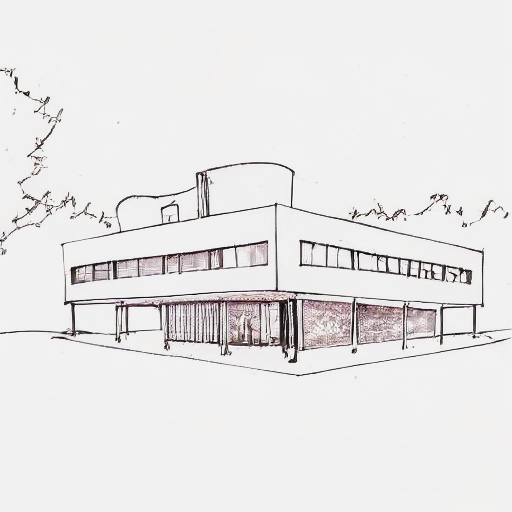

Step  0   0.5148135423660278
0.8
0.15


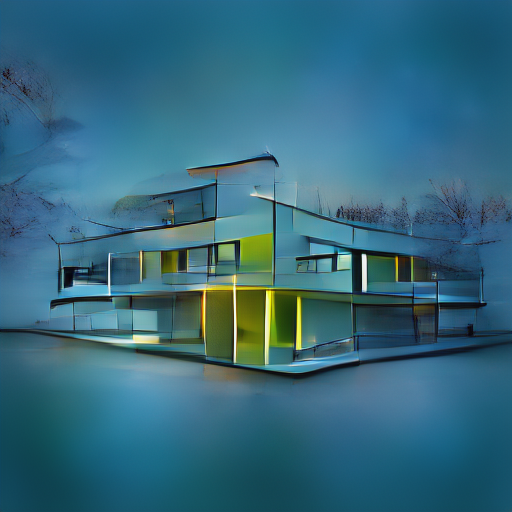

Step  5   0.4234103262424469
0.460117667420032
0.08291796067500631


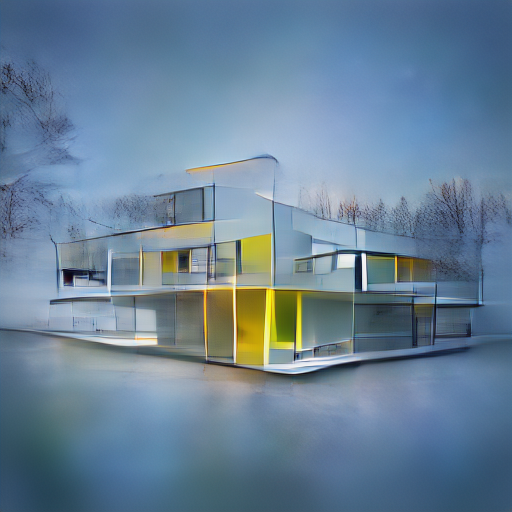

Step  10   0.41405045986175537
0.3193337956544064
0.05513167019494862


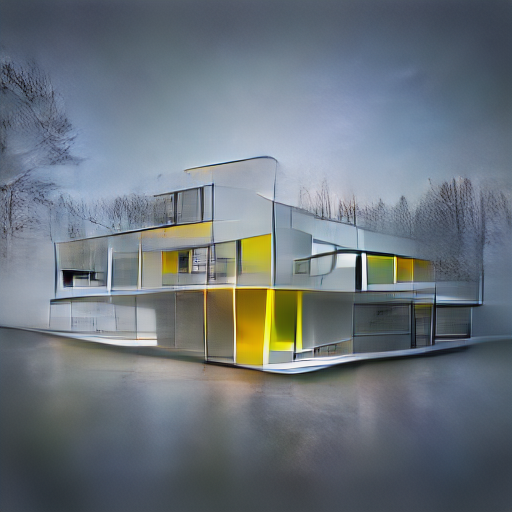

Step  15   0.4112589359283447
0.2113065313764726
0.033810499613777495


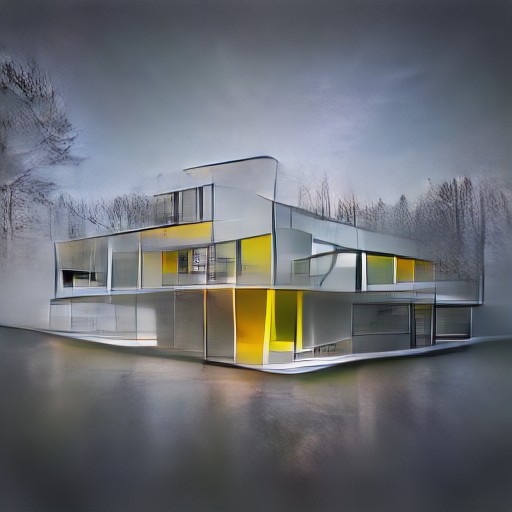

Step  20   0.40976682305336
0.12023533484006399
0.015835921350012633


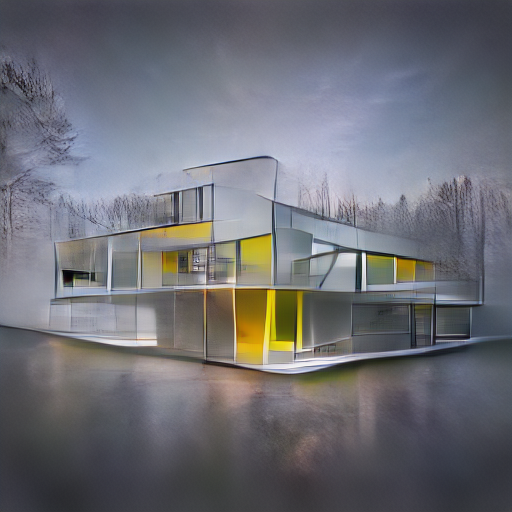

Step  25   0.41412413120269775
0.05535511819391392
0.0030306154330093094


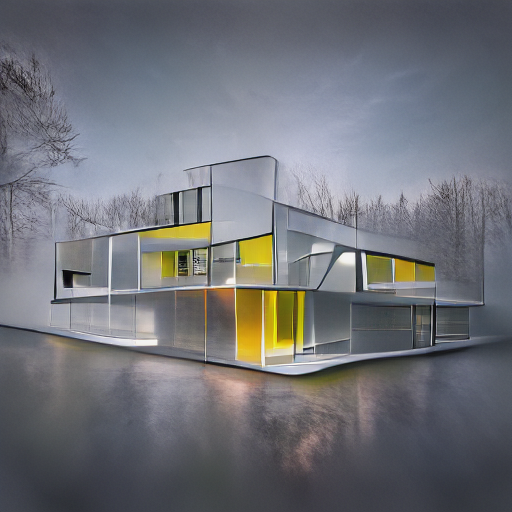

Step  30   0.40955597162246704
0.05535511819391392
0.0030306154330093094


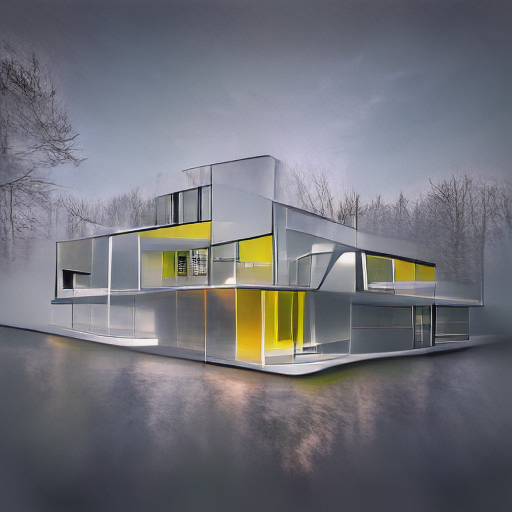

Step  35   0.4098283350467682
0.05535511819391392
0.0030306154330093094


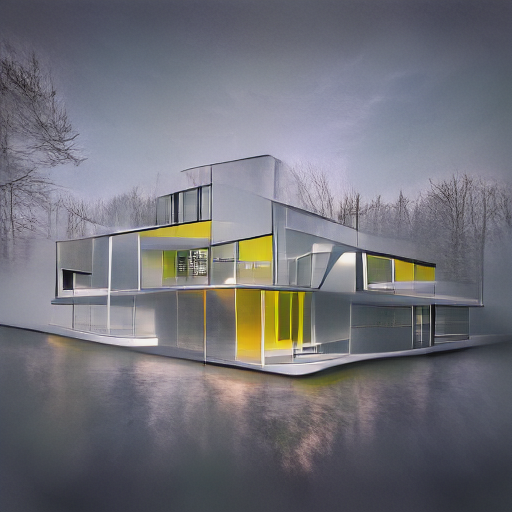

Step  40   0.41181665658950806
0.05535511819391392
0.0030306154330093094


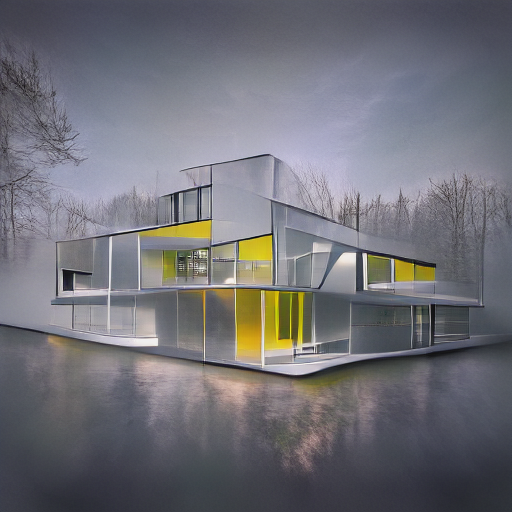

Step  45   0.4086489975452423
0.05535511819391392
0.0030306154330093094


In [129]:
#@title <font color='red'>Generate images</font> {vertical-output: true}

torch.set_grad_enabled(True)
import gc
from torchvision import transforms
import math
print("Steps", steps)


torch.cuda.empty_cache()
gc.collect()

from google.colab import output
output.eval_js('var bell = new Audio("https://freesound.org/data/previews/106/106807_19258-lq.ogg");')

sharpness = torch.zeros((1,1,448//16,448//16)).float().to(DEVICE).requires_grad_(True)

optimizer = torch.optim.AdamW([{'params': img_root},{'params': sharpness, 'lr': 0.01}], lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay)

def train(i):
  global img_root
  #img_root.data.clamp_(min=-8,max=8)
  optimizer.zero_grad()
  with torch.set_grad_enabled(True):

    img_test_raw = decode_with_vqgan(img_root, model16384)
    img_test     = format_image(img_test_raw.squeeze(0)).unsqueeze(0)
    #Nah I decided I'd rather not.
    #sharp_mask   = TF.resize(sharpness,(448,448))
    #sharp_mask   = HardTanh(sharp_mask)
    #highpass     = img_test - TF.gaussian_blur(img_test, 3)
    #img_test    = HardTanh(sharp_mask * highpass + img_test)

    loss = Loss_Check(img_test[0], prompt)

    clip_check = torch.abs(img_test_raw - torch.tanh(img_test_raw+img_test_raw**5*0.5))
    loss += clip_check.mean() * 0.4
    loss += torch.abs(img_test.mean() - 0.4)**2 * 0.2
    loss += torch.abs(img_test.std() - 0.3)**2 * 0.2
    #Nah this didn't work good. Was trying to get a differentiable smooth min/max
    #but I can't seem to get a range that actually gets min / max adjacent values
    #without also running the risk of fucking up big. Sucks my ass.
    #loss += torch.abs((img_test**15).mean()**(1/15) - 0.68)**2 * 0.2
    #loss += torch.abs(((1-img_test)**15).mean()**(1/15) - 0.78)**2 * 0.2

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #code for zoom
  modifyEvery = modify_steps
  if i%modifyEvery==0:
    speed = 0.01
    amount = math.sin(i*speed)
    

    img_test_raw = decode_with_vqgan(img_root.detach().clone(), model16384)
    img_test_raw = transforms.functional.affine(img_test_raw.squeeze(0),affine_angle,affine_translate,affine_scale,affine_shear).unsqueeze(0)
    #img_test_raw = transforms.functional.affine(img_test_raw.squeeze(0),0, (0,0), 1, 0).unsqueeze(0)
    img_root = encode_with_vqgan(img_test_raw, model16384).to(DEVICE).float().requires_grad_(True)
    optimizer.param_groups[0]['params'] = [img_root]

  if i < lr_decay_steps or i < wd_decay_steps:
    if i < lr_decay_steps:
      new_lr = ((i % lr_decay_steps) / lr_decay_steps)**0.5 * (lr_min - learning_rate) + learning_rate
      optimizer.param_groups[0]['lr'] = new_lr
    if i < wd_decay_steps:
      new_wd = ((i % wd_decay_steps) / wd_decay_steps)**0.5 * (wd_min - weight_decay) + weight_decay
      optimizer.param_groups[0]['weight_decay'] = new_wd
  #zoom value
  #if i%modifyEvery==0:
  if i%save_steps==0:
    with torch.set_grad_enabled(False):
      img_out = T.ToPILImage()(img_test[0]).convert("RGB")
      img_out.save('output/' + str(i).zfill(8) + '.jpg')
  

    if i % 1 == 0:
        display.display(img_out)
        #display.display(T.ToPILImage()(sharpness[0].clamp(-1,1)*0.5 + 0.5).convert("RGB"))
        print('Step ', i, ' ', loss.item())
        print(optimizer.param_groups[0]['lr'])
        print(optimizer.param_groups[0]['weight_decay'])
        #print('Min ', img_root.min().item())
        #print('Max ', img_root.max().item())
        #print((img_test**15).mean()**(1/15))
        #print(((1-img_test)**15).mean()**(1/15))
        del img_out
    
    
for i in range(steps):
    run = train(i)
output.eval_js('bell.play();')

In [123]:
#@title <font color='red'> Render Video </font> {vertical-output: true}

!ls output/*.jpg


#!ffmpeg -pattern_type glob -r 15/3 -i './output/*.png' -frames:v 600 -filter:v "minterpolate='fps=15:mb_size=8:search_param=8:vsbmc=0:scd=none:mc_mode=obmc:me_mode=bidir'" -vcodec libx264 -crf 30 -pix_fmt yuv420p out.mp4
#!ffmpeg -pattern_type glob -r 30 -i './output/*.png' -filter:v "scale=512x512" -vcodec libx264 -crf 28 -pix_fmt yuv420p out.mp4
#!ffmpeg -loop 1 -framerate 30 -t 1 -i 'picsum.jpg' -pattern_type glob -r 30 -i './output/*.png' -filter_complex '[0:0] [1:0] concat=n=2:v=1:a=0, scale=512x512' -vcodec libx264 -crf 24 -pix_fmt yuv420p out.mp4
!ffmpeg -pattern_type glob -r 10 -i './output/*.jpg' -frames:v 325 -vcodec libx264 -crf 24 -pix_fmt yuv420p /content/out.mp4

#!ffmpeg -pattern_type glob -r 15/2 -i './output/*.jpg' -frames:v 2250 -filter:v "crop=224:224:158:152, minterpolate='fps=15:mb_size=8:search_param=8:vsbmc=0:scd=none:mc_mode=obmc:me_mode=bidir', scale=512x512" -vcodec libx264 -crf 32 -pix_fmt yuv420p out.mp4

#-filter:v "crop=224:224:158:152"

ls: cannot access 'output/*.jpg': No such file or directory
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --e

In [124]:
#@title <font color='#429feb'>Display Video</font> {vertical-output: true}


from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

FileNotFoundError: ignored